In [61]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from lime import lime_tabular
import time
import random


In [62]:
# Load the HIGGS dataset
# Assume the dataset has been downloaded and saved as 'HIGGS.csv'
data = pd.read_csv('HIGGS.csv', header=None)

# Check the first few rows of the dataset
data.shape
data = data.sample(frac=0.02, random_state=42)
data.shape

(4960, 29)

                0            1            2            3            4   \
count  4960.000000  4960.000000  4960.000000  4960.000000  4960.000000   
mean      0.527823     0.989365     0.007072     0.009512     0.992191   
std       0.499276     0.558806     1.004127     1.016759     0.588059   
min       0.000000     0.274697    -2.416471    -1.741953     0.006300   
25%       0.000000     0.588511    -0.741244    -0.891628     0.575320   
50%       1.000000     0.850443     0.013094     0.015953     0.887512   
75%       1.000000     1.233390     0.720926     0.898321     1.283895   
max       1.000000     5.273407     2.399805     1.742681     4.519092   

                5            6            7            8            9   ...  \
count  4960.000000  4960.000000  4960.000000  4960.000000  4960.000000  ...   
mean      0.003261     0.986951     0.010647    -0.020043     0.989714  ...   
std       1.000182     0.477867     1.006882     1.009065     1.025166  ...   
min      -1.74388

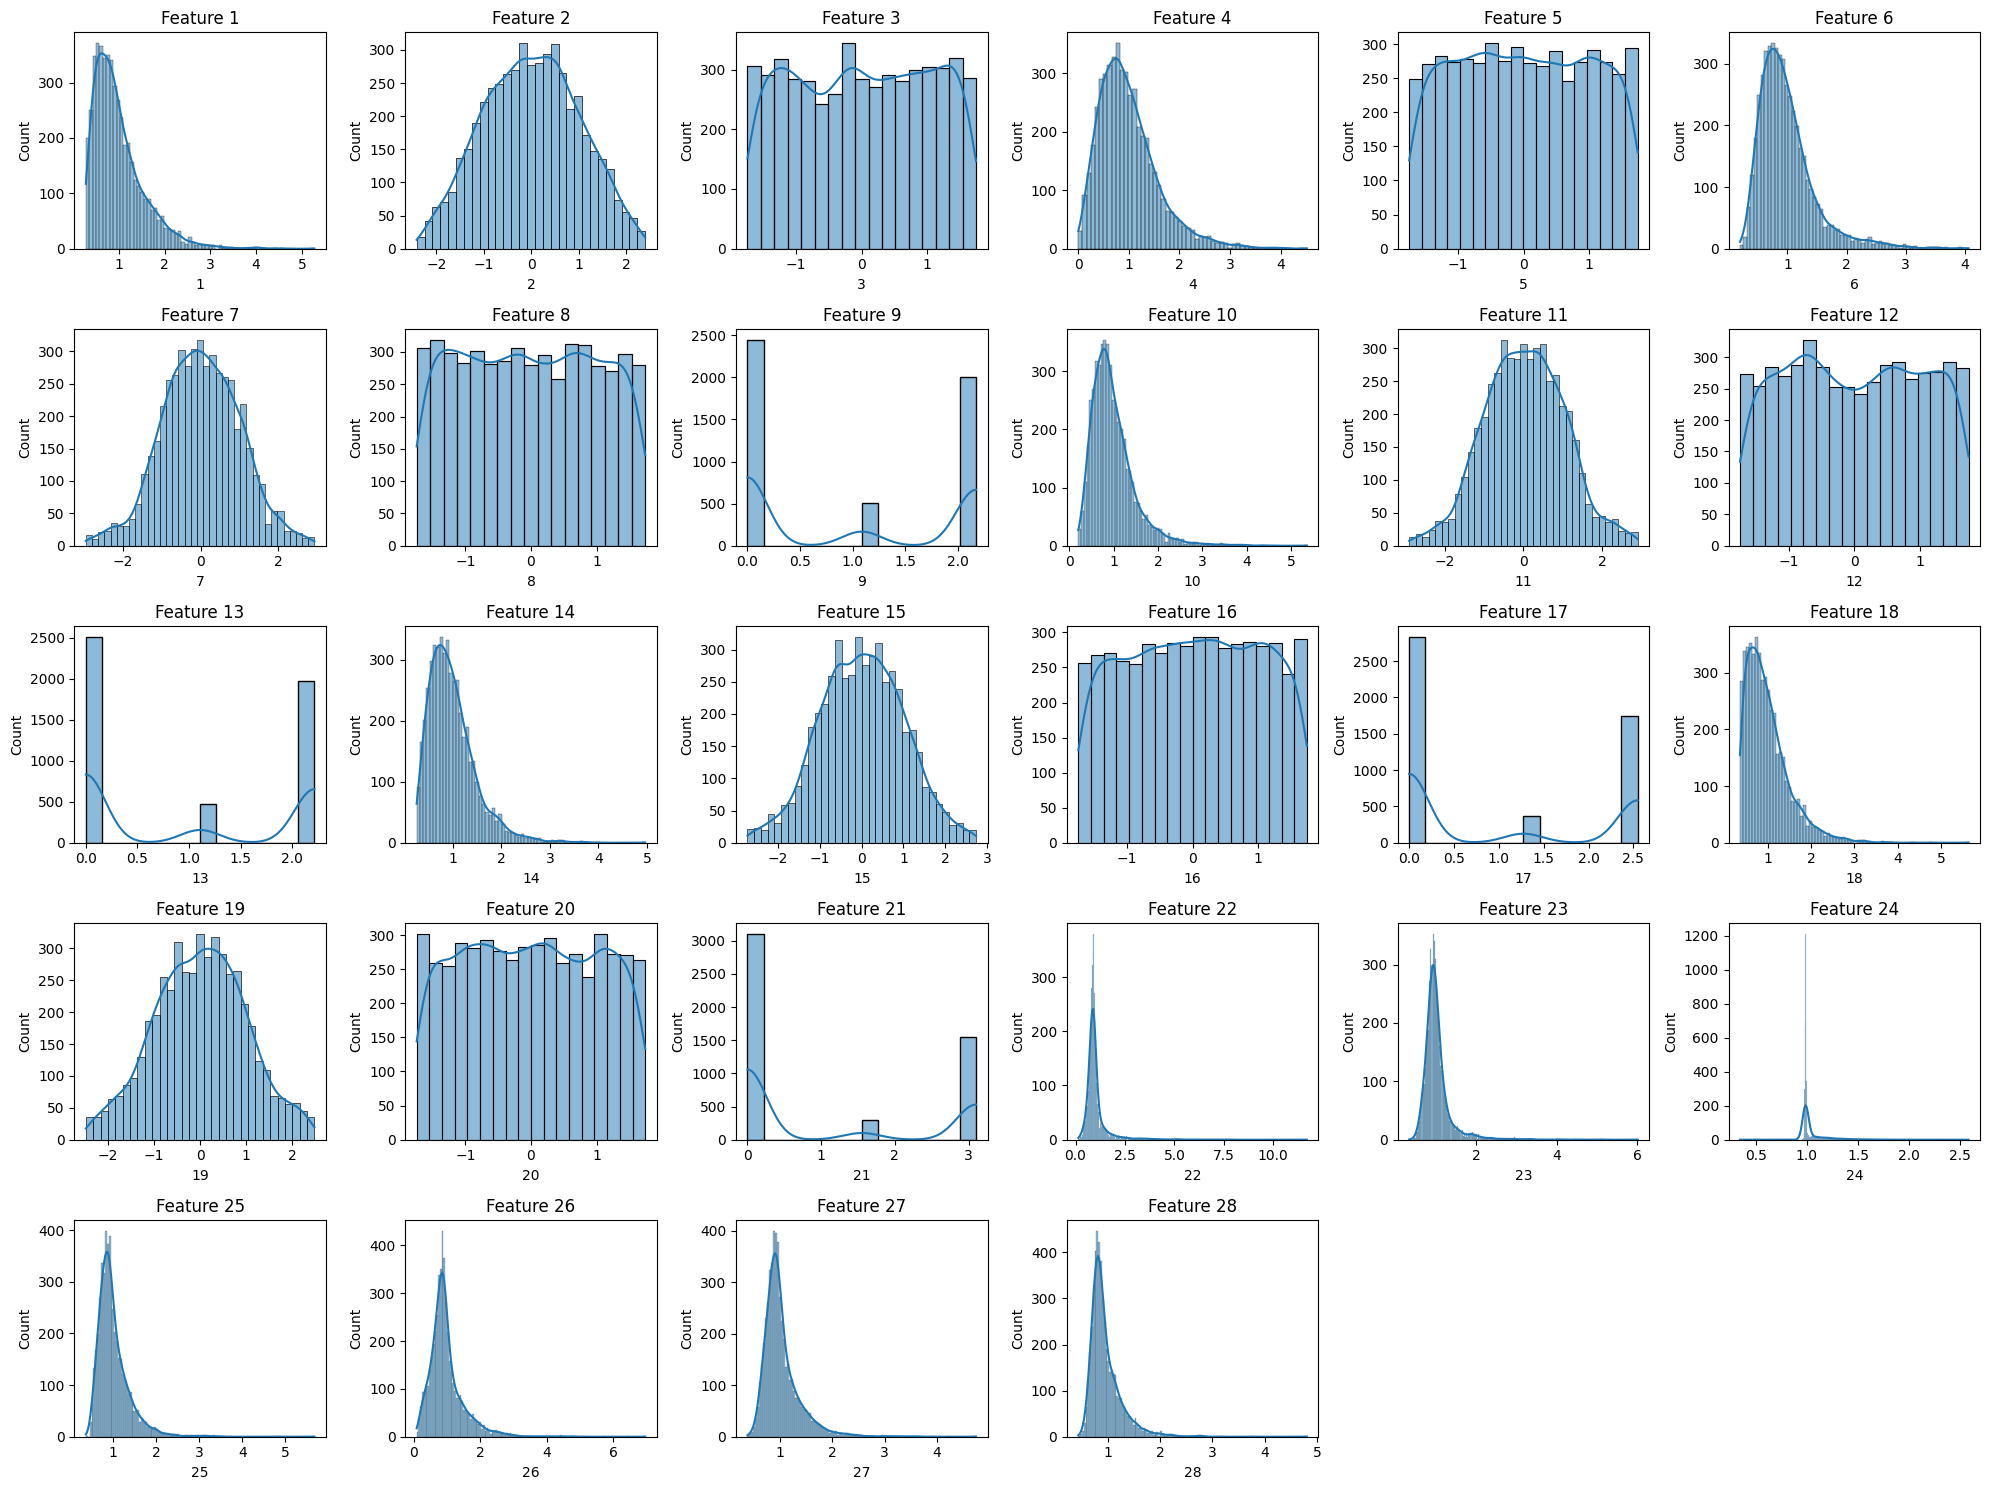

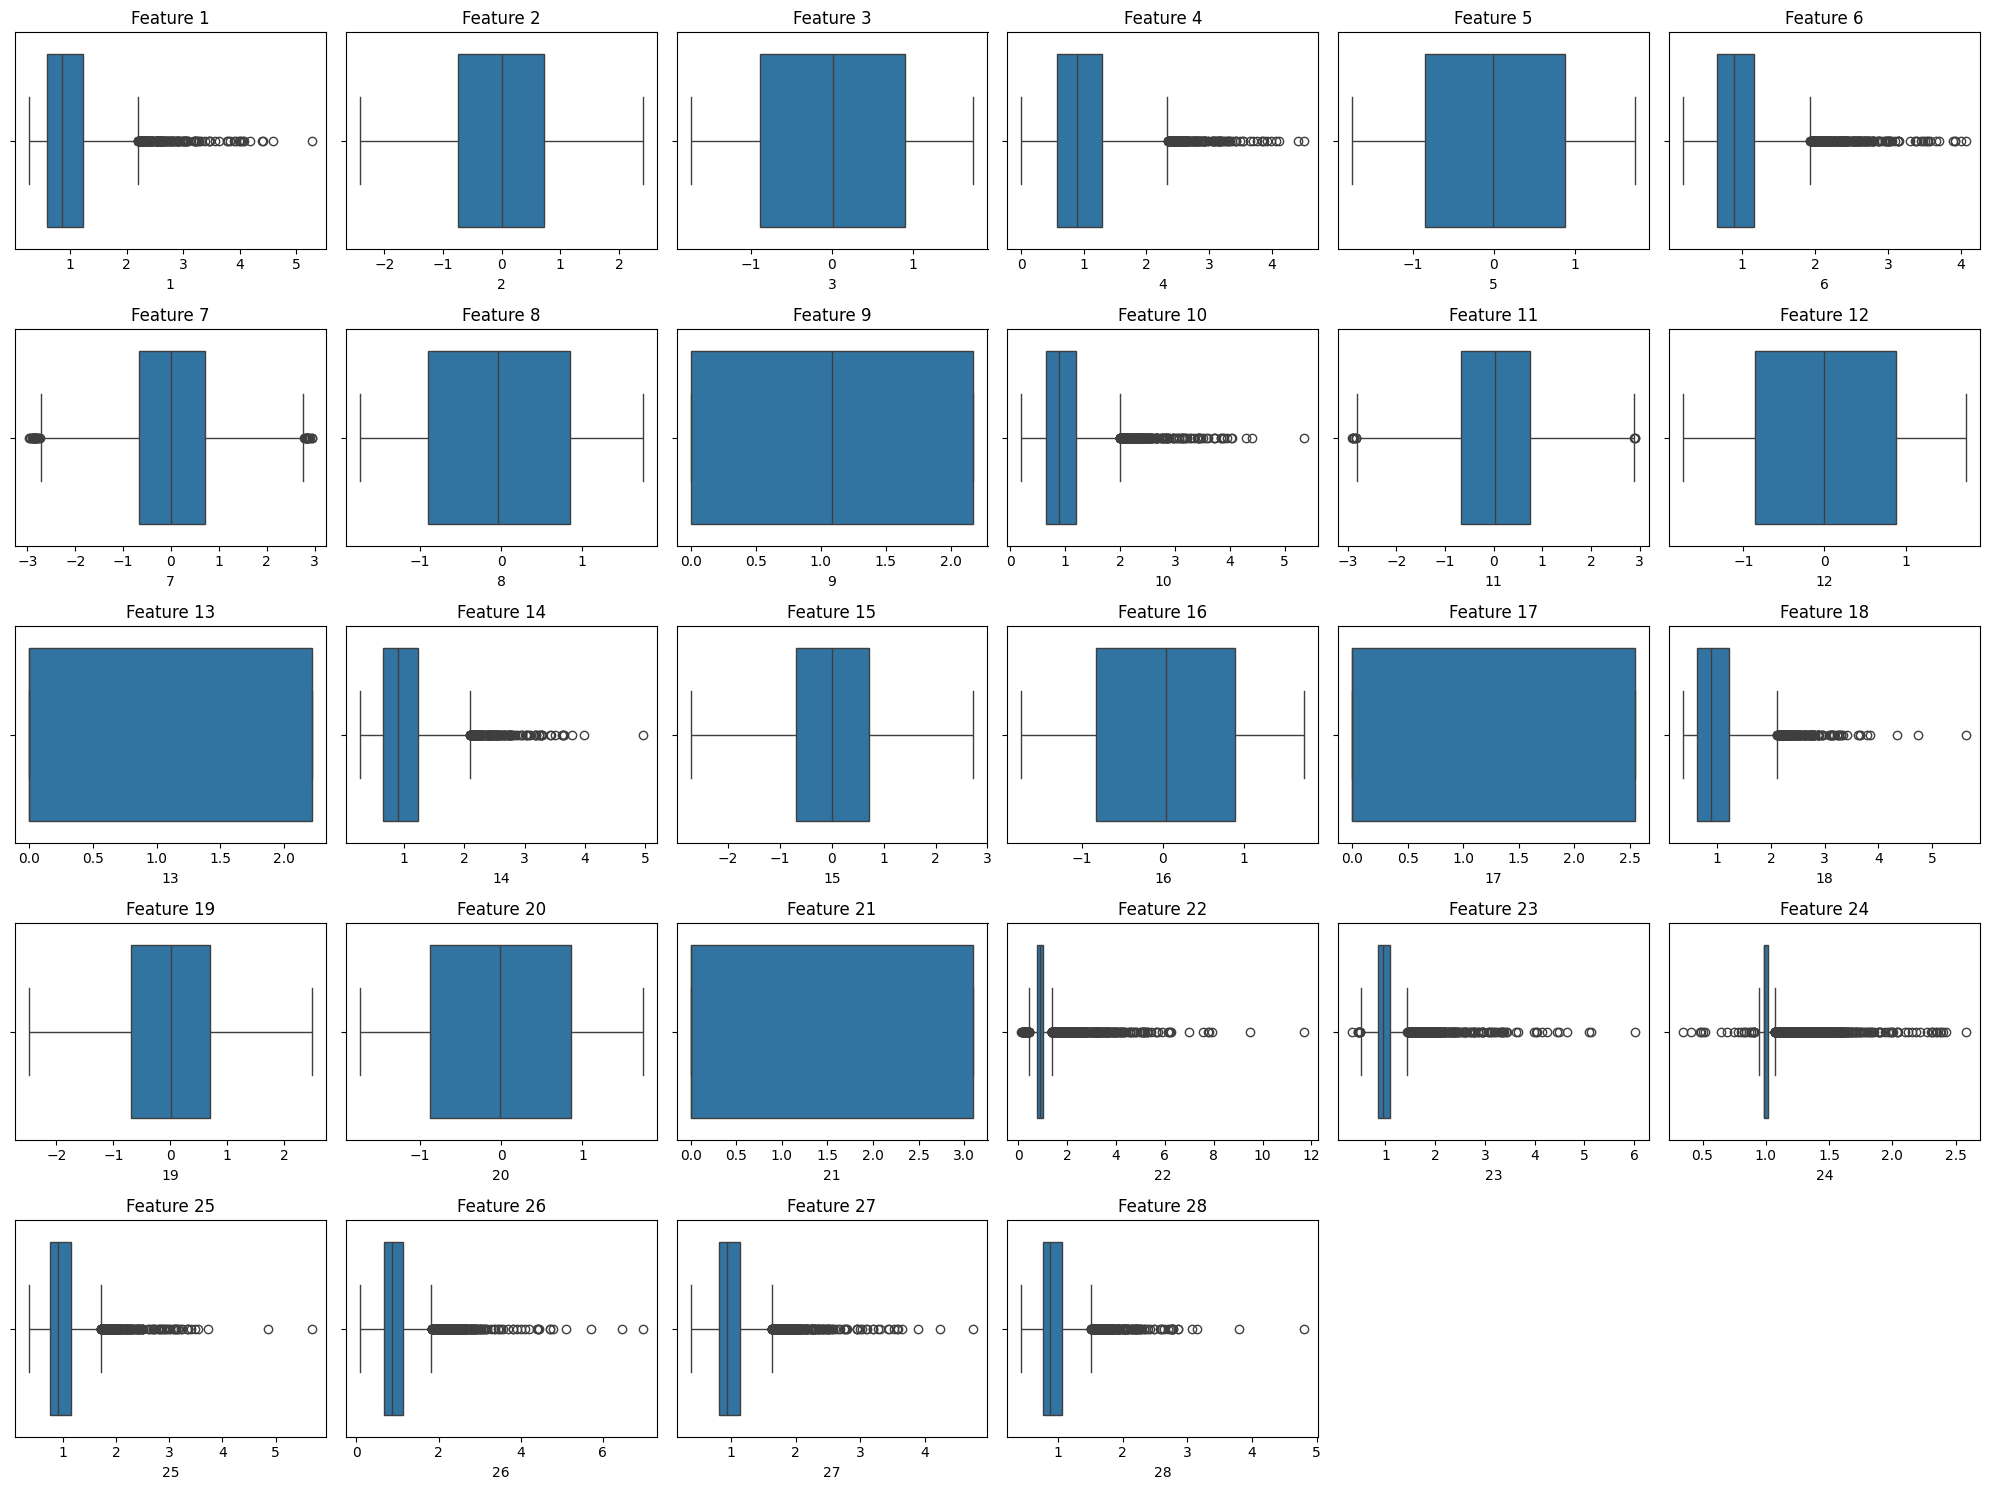

In [63]:
# 1. Check basic statistics
print(data.describe())

# Define features and target
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]   # Target

# 2. Visualize feature distributions
plt.figure(figsize=(20, 15))
for i in range(1, 29):
    plt.subplot(5, 6, i)
    sns.histplot(X.iloc[:, i-1], kde=True)
    plt.title(f'Feature {i}')
plt.tight_layout()
plt.show()

# 3. Identify outliers using box plots
plt.figure(figsize=(20, 15))
for i in range(1, 29):
    plt.subplot(5, 6, i)
    sns.boxplot(x=X.iloc[:, i-1])
    plt.title(f'Feature {i}')
plt.tight_layout()
plt.show()

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
# Create polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

print(f"Original features shape: {X_scaled.shape}")
print(f"Polynomial features shape: {X_poly.shape}")

Original features shape: (4960, 28)
Polynomial features shape: (4960, 406)


In [66]:
# Selecting the top 20 features using SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_poly, y)

print(f"Selected features shape (SelectKBest): {X_selected.shape}")

Selected features shape (SelectKBest): (4960, 15)


In [67]:
# Assuming the feature-selected dataset from Part 1
# X_final refers to the features selected with SelectKBest or RFE
# y refers to the target variable (Signal vs. Background)
X_final = X_selected
y_final = y
# Set up cross-validation
cv = StratifiedKFold(n_splits=5)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')
}

### Step 1: Linear SVM with Cross-Validation ###

# Initialize a Linear SVM
linear_svc = SVC(kernel='linear', probability=True)

# Perform cross-validation and compute the scores
cv_results = cross_validate(linear_svc, X_final, y, cv=cv, scoring=scoring)

# Report cross-validation metrics for Linear SVM
print("Linear SVM Results:")
print(f"Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"F1 Score: {np.mean(cv_results['test_f1']):.4f}")
print(f"AUC: {np.mean(cv_results['test_roc_auc']):.4f}")

Linear SVM Results:
Accuracy: 0.6300
Precision: 0.6157
Recall: 0.7960
F1 Score: 0.6942
AUC: 0.6754


In [68]:
# Initialize a Linear SVM with SGD
sgd_svc = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)

# Use CalibratedClassifierCV to enable probability estimates
calibrated_sgd_svc = CalibratedClassifierCV(sgd_svc, method='sigmoid', cv=5)

# Perform cross-validation and compute the scores with Calibrated SGD SVM
cv_results_sgd = cross_validate(calibrated_sgd_svc, X_final, y, cv=cv, scoring=scoring)

# Report cross-validation metrics for Calibrated SGD SVM
print("\nCalibrated SGD SVM Results:")
print(f"Accuracy: {np.mean(cv_results_sgd['test_accuracy']):.4f}")
print(f"Precision: {np.mean(cv_results_sgd['test_precision']):.4f}")
print(f"Recall: {np.mean(cv_results_sgd['test_recall']):.4f}")
print(f"F1 Score: {np.mean(cv_results_sgd['test_f1']):.4f}")
print(f"AUC: {np.mean(cv_results_sgd['test_roc_auc']):.4f}")


Calibrated SGD SVM Results:
Accuracy: 0.6115
Precision: 0.5905
Recall: 0.8613
F1 Score: 0.7004
AUC: 0.6676


In [69]:
# Function to evaluate and print model performance
def evaluate_model(model, X, y):
    accuracy = accuracy_score(y, model.predict(X))
    precision = precision_score(y, model.predict(X))
    recall = recall_score(y, model.predict(X))
    f1 = f1_score(y, model.predict(X))
    auc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

# Ensure X_final and y_final are defined
X_final = X_selected  # Replace with your final feature set variable if different
y_final = y           # Replace with your target label variable if different

# Polynomial Kernel Evaluation
for degree in [2, 3, 4]:
    print(f"\nPolynomial Kernel (Degree = {degree})")

    # Define parameter grid for Polynomial kernel with the current degree
    param_grid_poly = {
        'C': [0.1, 1, 10],
        'degree': [degree],
        'kernel': ['poly']
    }

    # Set up GridSearchCV for Polynomial kernel
    grid_poly = GridSearchCV(SVC(probability=True), param_grid_poly, cv=5, scoring='accuracy')

    # Measure training time and fit the model
    start_time = time.time()
    grid_poly.fit(X_final, y_final)
    end_time = time.time()

    # Print best parameters and evaluation metrics for Polynomial kernel
    print("Best Parameters:", grid_poly.best_params_)
    print(f"Training time: {end_time - start_time:.2f} seconds")
    evaluate_model(grid_poly.best_estimator_, X_final, y_final)


Polynomial Kernel (Degree = 2)
Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}
Training time: 87.41 seconds
Accuracy: 0.6413
Precision: 0.6118
Recall: 0.8770
F1 Score: 0.7208
AUC: 0.7204

Polynomial Kernel (Degree = 3)
Best Parameters: {'C': 10, 'degree': 3, 'kernel': 'poly'}
Training time: 95.98 seconds
Accuracy: 0.6476
Precision: 0.6080
Recall: 0.9351
F1 Score: 0.7369
AUC: 0.7582

Polynomial Kernel (Degree = 4)
Best Parameters: {'C': 10, 'degree': 4, 'kernel': 'poly'}
Training time: 106.44 seconds
Accuracy: 0.6389
Precision: 0.5972
Recall: 0.9706
F1 Score: 0.7394
AUC: 0.7547


In [70]:
# Function to evaluate and print model performance
def evaluate_model(model, X, y):
    accuracy = accuracy_score(y, model.predict(X))
    precision = precision_score(y, model.predict(X))
    recall = recall_score(y, model.predict(X))
    f1 = f1_score(y, model.predict(X))
    auc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

# Ensure X_final and y_final are defined
X_final = X_selected  # Replace with your final feature set variable if different
y_final = y           # Replace with your target label variable if different

# Define the possible C values
C_values = [0.1, 1, 10]

# Loop over each `gamma` and select a random `C` value for each iteration
for gamma in [0.01, 0.001, 1]:
    # Randomly select a C value for each gamma
    C = random.choice(C_values)

    print(f"\nRBF Kernel (C = {C}, gamma = {gamma})")

    # Initialize the SVM model with RBF kernel and the current C and gamma values
    rbf_svc = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)

    # Measure training time and fit the model
    start_time = time.time()
    rbf_svc.fit(X_final, y_final)
    end_time = time.time()

    # Print evaluation metrics for the current model
    print(f"Training time: {end_time - start_time:.2f} seconds")
    evaluate_model(rbf_svc, X_final, y_final)



RBF Kernel (C = 1, gamma = 0.01)
Training time: 6.79 seconds
Accuracy: 0.6464
Precision: 0.6245
Recall: 0.8277
F1 Score: 0.7119
AUC: 0.7218

RBF Kernel (C = 1, gamma = 0.001)
Training time: 5.93 seconds
Accuracy: 0.6079
Precision: 0.5823
Recall: 0.9091
F1 Score: 0.7099
AUC: 0.6756

RBF Kernel (C = 1, gamma = 1)
Training time: 6.85 seconds
Accuracy: 0.9089
Precision: 0.8898
Recall: 0.9442
F1 Score: 0.9162
AUC: 0.9606


In [71]:
# Function to evaluate and print model performance
def evaluate_model(model, X, y):
    accuracy = accuracy_score(y, model.predict(X))
    precision = precision_score(y, model.predict(X))
    recall = recall_score(y, model.predict(X))
    f1 = f1_score(y, model.predict(X))
    auc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

# Ensure X_final and y_final are defined
X_final = X_selected  # Replace with your final feature set variable if different
y_final = y           # Replace with your target label variable if different

# Define the possible C values
C_values = [0.1, 1, 10]

# Loop over each `gamma` and select a random `C` value for each iteration
for gamma in [0.01, 0.001, 1]:
    # Randomly select a C value for each gamma
    C = random.choice(C_values)

    print(f"\nSigmoid Kernel (C = {C}, gamma = {gamma})")

    # Initialize the SVM model with sigmoid kernel and the current C and gamma values
    sigmoid_svc = SVC(kernel='sigmoid', C=C, gamma=gamma, probability=True)

    # Measure training time and fit the model
    start_time = time.time()
    sigmoid_svc.fit(X_final, y_final)
    end_time = time.time()

    # Print evaluation metrics for the current model
    print(f"Training time: {end_time - start_time:.2f} seconds")
    evaluate_model(sigmoid_svc, X_final, y_final)



Sigmoid Kernel (C = 1, gamma = 0.01)
Training time: 9.89 seconds
Accuracy: 0.5982
Precision: 0.5937
Recall: 0.7563
F1 Score: 0.6652
AUC: 0.6103

Sigmoid Kernel (C = 0.1, gamma = 0.001)
Training time: 9.12 seconds
Accuracy: 0.5395
Precision: 0.5344
Recall: 0.9912
F1 Score: 0.6944
AUC: 0.6521

Sigmoid Kernel (C = 0.1, gamma = 1)
Training time: 7.28 seconds
Accuracy: 0.5177
Precision: 0.5430
Recall: 0.5451
F1 Score: 0.5440
AUC: 0.5198


Hyperparameter Tuning for Polynomial Kernel
Best parameters for Polynomial Kernel: {'gamma': 'auto', 'degree': 2, 'C': 10}
Best cross-validation AUC score: 0.6840

Hyperparameter Tuning for RBF Kernel
Best parameters for RBF Kernel: {'gamma': 0.01, 'C': 100}
Best cross-validation AUC score: 0.7197


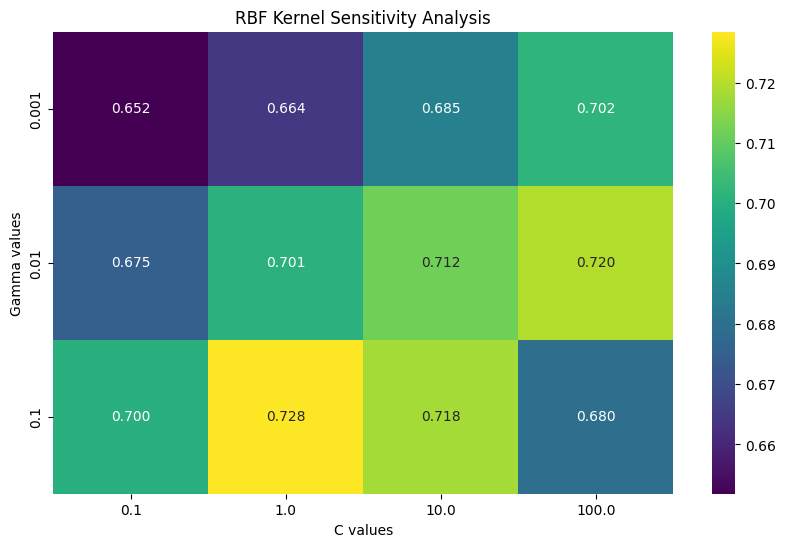

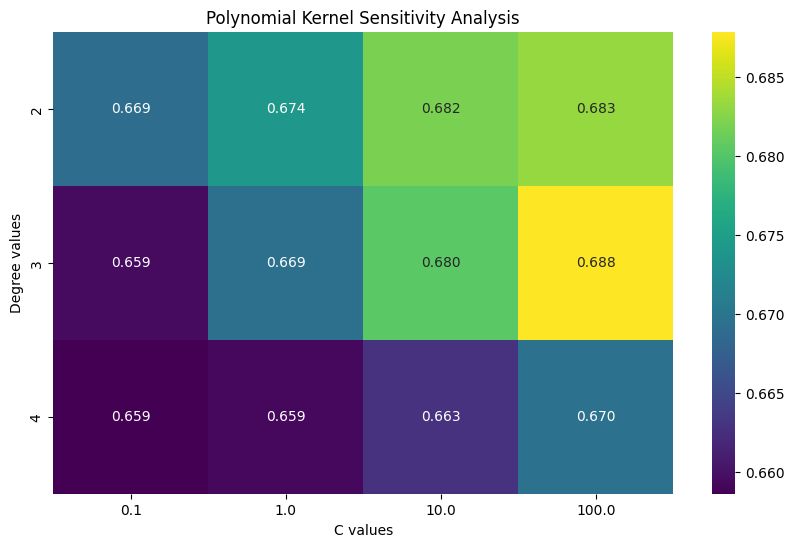

In [72]:
# Ensure X_final and y_final are defined
X_final = X_selected  # Replace with your final feature set variable if different
y_final = y           # Replace with your target label variable if different

# Function to evaluate and return model performance
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    auc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    return accuracy, precision, recall, f1, auc

# 1. Hyperparameter Tuning for Polynomial Kernel
print("Hyperparameter Tuning for Polynomial Kernel")
poly_param_dist = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

poly_svc = SVC(kernel='poly', probability=True)
poly_search = RandomizedSearchCV(poly_svc, poly_param_dist, n_iter=10, cv=3, scoring='roc_auc', random_state=42)
poly_search.fit(X_final, y_final)

poly_best_params = poly_search.best_params_
poly_best_score = poly_search.best_score_

print(f"Best parameters for Polynomial Kernel: {poly_best_params}")
print(f"Best cross-validation AUC score: {poly_best_score:.4f}")

# 2. Hyperparameter Tuning for RBF Kernel
print("\nHyperparameter Tuning for RBF Kernel")
rbf_param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 'scale', 'auto']
}

rbf_svc = SVC(kernel='rbf', probability=True)
rbf_search = RandomizedSearchCV(rbf_svc, rbf_param_dist, n_iter=10, cv=3, scoring='roc_auc', random_state=42)
rbf_search.fit(X_final, y_final)

rbf_best_params = rbf_search.best_params_
rbf_best_score = rbf_search.best_score_

print(f"Best parameters for RBF Kernel: {rbf_best_params}")
print(f"Best cross-validation AUC score: {rbf_best_score:.4f}")

# 3. Hyperparameter Sensitivity Analysis (Visualizing)
# Sensitivity Analysis for RBF Kernel
C_values = [0.1, 1, 10, 100]
gamma_values = [0.001, 0.01, 0.1]

results_rbf = []

for gamma in gamma_values:
    scores = []
    for C in C_values:
        rbf_svc = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)
        scores.append(np.mean(cross_val_score(rbf_svc, X_final, y_final, cv=3, scoring='roc_auc')))
    results_rbf.append(scores)

results_rbf = pd.DataFrame(results_rbf, index=gamma_values, columns=C_values)

# Plot heatmap for RBF Kernel sensitivity analysis
plt.figure(figsize=(10, 6))
sns.heatmap(results_rbf, annot=True, fmt=".3f", cmap='viridis')
plt.title('RBF Kernel Sensitivity Analysis')
plt.xlabel('C values')
plt.ylabel('Gamma values')
plt.show()

# Sensitivity Analysis for Polynomial Kernel
degree_values = [2, 3, 4]

results_poly = []

for degree in degree_values:
    scores = []
    for C in C_values:
        poly_svc = SVC(kernel='poly', C=C, degree=degree, probability=True)
        scores.append(np.mean(cross_val_score(poly_svc, X_final, y_final, cv=3, scoring='roc_auc')))
    results_poly.append(scores)

results_poly = pd.DataFrame(results_poly, index=degree_values, columns=C_values)

# Plot heatmap for Polynomial Kernel sensitivity analysis
plt.figure(figsize=(10, 6))
sns.heatmap(results_poly, annot=True, fmt=".3f", cmap='viridis')
plt.title('Polynomial Kernel Sensitivity Analysis')
plt.xlabel('C values')
plt.ylabel('Degree values')
plt.show()


Results Summary:
       Kernel    C Degree Gamma  Accuracy  Precision    Recall  F1 Score  \
0  Polynomial   10      2  auto  0.643750   0.615218  0.867838  0.720013   
1         RBF  100      -  0.01  0.717137   0.702029  0.806341  0.750578   

        AUC  
0  0.722959  
1  0.789554  


<Figure size 1200x600 with 0 Axes>

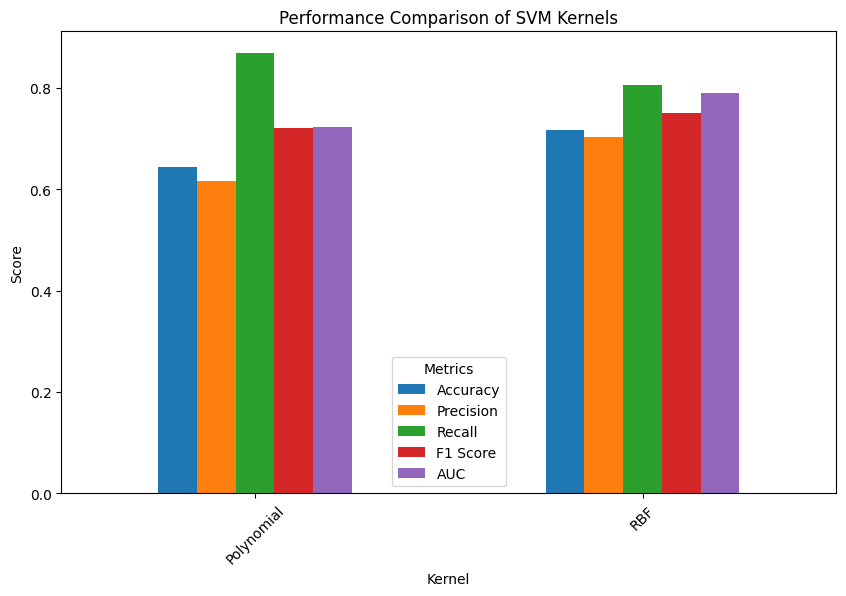

<Figure size 1000x600 with 0 Axes>

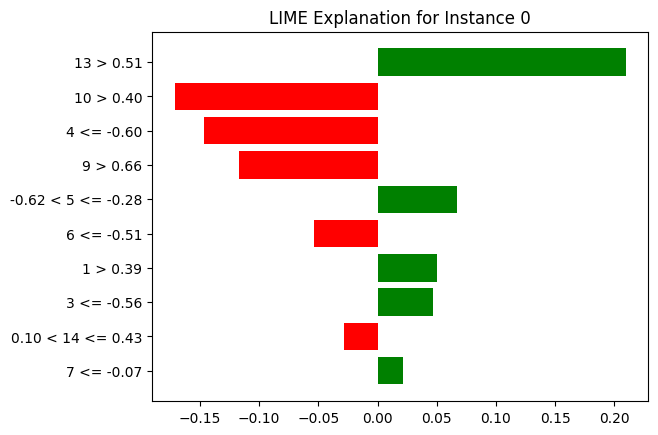

In [74]:
# Assume X_final and y_final are already defined from previous parts
# X_final should be a pandas DataFrame, if it's a numpy array, convert it back to DataFrame
X_final = pd.DataFrame(X_selected)  # Ensure this is a DataFrame
y_final = y  # Target label variable

# Best parameters and scores from previous sections
# Assume we stored best params and scores for each kernel
best_params_poly = poly_best_params  # From previous tuning
best_params_rbf = rbf_best_params    # From previous tuning

# Evaluate the best polynomial kernel model
poly_svc = SVC(kernel='poly', **best_params_poly, probability=True)
poly_svc.fit(X_final, y_final)
poly_metrics = evaluate_model(poly_svc, X_final, y_final)

# Evaluate the best RBF kernel model
rbf_svc = SVC(kernel='rbf', **best_params_rbf, probability=True)
rbf_svc.fit(X_final, y_final)
rbf_metrics = evaluate_model(rbf_svc, X_final, y_final)

# Summarizing the results
results_summary = pd.DataFrame({
    'Kernel': ['Polynomial', 'RBF'],
    'C': [best_params_poly['C'], best_params_rbf['C']],
    'Degree': [best_params_poly['degree'], '-'],  # Degree only for polynomial
    'Gamma': [best_params_poly['gamma'], best_params_rbf['gamma']],
    'Accuracy': [poly_metrics[0], rbf_metrics[0]],
    'Precision': [poly_metrics[1], rbf_metrics[1]],
    'Recall': [poly_metrics[2], rbf_metrics[2]],
    'F1 Score': [poly_metrics[3], rbf_metrics[3]],
    'AUC': [poly_metrics[4], rbf_metrics[4]]
})

print("\nResults Summary:")
print(results_summary)

# Visualize performance comparison
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
results_summary.set_index('Kernel')[metrics].plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of SVM Kernels')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

# LIME for Explainability
# Choose the best-performing model (you can select based on AUC or any other metric)
best_model = rbf_svc  # Replace with poly_svc if you found it better based on metrics

# Create LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_final.values,  # Use the values of DataFrame
    feature_names=X_final.columns.tolist(),  # Get column names as a list
    class_names=['Class 0', 'Class 1'],  # Adjust class names according to your dataset
    mode='classification'
)

# Choose a single instance to explain
instance_index = 0  # Change this to explain different instances
instance_to_explain = X_final.iloc[instance_index]

# Generate LIME explanation
exp = explainer.explain_instance(
    data_row=instance_to_explain.values,  # Use values of the instance
    predict_fn=best_model.predict_proba
)

# Visualize the explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Alternatively, plot the explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title(f'LIME Explanation for Instance {instance_index}')
plt.show()
